# Advanced Lane Finding Project

The goals / steps of this project are the following:

**1.**  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.  
**2.**  Apply a distortion correction to raw images.   
**3.**  Use color transforms, gradients, etc., to create a thresholded binary image.    
**4.**  Apply a perspective transform to rectify binary image ("birds-eye view").  
**5.**  Detect lane pixels and fit to find the lane boundary.  
**6.**  Determine the curvature of the lane and vehicle position with respect to center.  
**7.**  Warp the detected lane boundaries back onto the original image.  
**8.**  Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.  


---
##### Required libraries

In [1]:
import math
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Import needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

---
## 1. Compute the camera calibration using chessboard images

#####  Plot function for later use

In [2]:
def plot_result(img_start,img_end,
                title_start='Original image',title_end='Modified image',
                gray_start=False,gray_end=False):
    ''' 
    Plot two images orizontally to better compare them, 
    usually before and after a transformation.
    A character array as title as well a gray color map specification 
    can be set for managing the result when calling.
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    if gray_start:        
        ax1.imshow(img_start,cmap='gray')
    else:
        ax1.imshow(img_start)
    ax1.set_title(title_start, fontsize=30) 
    
    if gray_end:        
        ax2.imshow(img_end,cmap='gray')
    else:
        ax2.imshow(img_end)
    ax2.set_title(title_end, fontsize=30)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

##### Undistortion pipeline

In [3]:
# Parameters
k = 0 # Used-images counter
plot_switch = False # For showing/not showing images when running

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images_list = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx,fname in enumerate(images_list):
    
    img = mpimg.imread(fname)
    image = np.copy(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    # else print a warning message
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        print("Image count: #",idx+1,fname) 
        if plot_switch:
            drawn_img = cv2.drawChessboardCorners(image, (9,6), corners, ret)
            plot_result(img,drawn_img)
        k +=1
    else:        
        print("*** Warning ***    Unused image:",fname)  
        if plot_switch:
            plot_result(img,img,title_end='... unchanged')
        
print("\nUsed",k, "images in total\n")

*** Warning ***    Unused image: ../camera_cal/calibration1.jpg
Image count: # 2 ../camera_cal/calibration10.jpg
Image count: # 3 ../camera_cal/calibration11.jpg
Image count: # 4 ../camera_cal/calibration12.jpg
Image count: # 5 ../camera_cal/calibration13.jpg
Image count: # 6 ../camera_cal/calibration14.jpg
Image count: # 7 ../camera_cal/calibration15.jpg
Image count: # 8 ../camera_cal/calibration16.jpg
Image count: # 9 ../camera_cal/calibration17.jpg
Image count: # 10 ../camera_cal/calibration18.jpg
Image count: # 11 ../camera_cal/calibration19.jpg
Image count: # 12 ../camera_cal/calibration2.jpg
Image count: # 13 ../camera_cal/calibration20.jpg
Image count: # 14 ../camera_cal/calibration3.jpg
*** Warning ***    Unused image: ../camera_cal/calibration4.jpg
*** Warning ***    Unused image: ../camera_cal/calibration5.jpg
Image count: # 17 ../camera_cal/calibration6.jpg
Image count: # 18 ../camera_cal/calibration7.jpg
Image count: # 19 ../camera_cal/calibration8.jpg
Image count: # 20 ../

##### Testing undistortion results

Testing undistortion on image:  ../camera_cal/calibration1.jpg


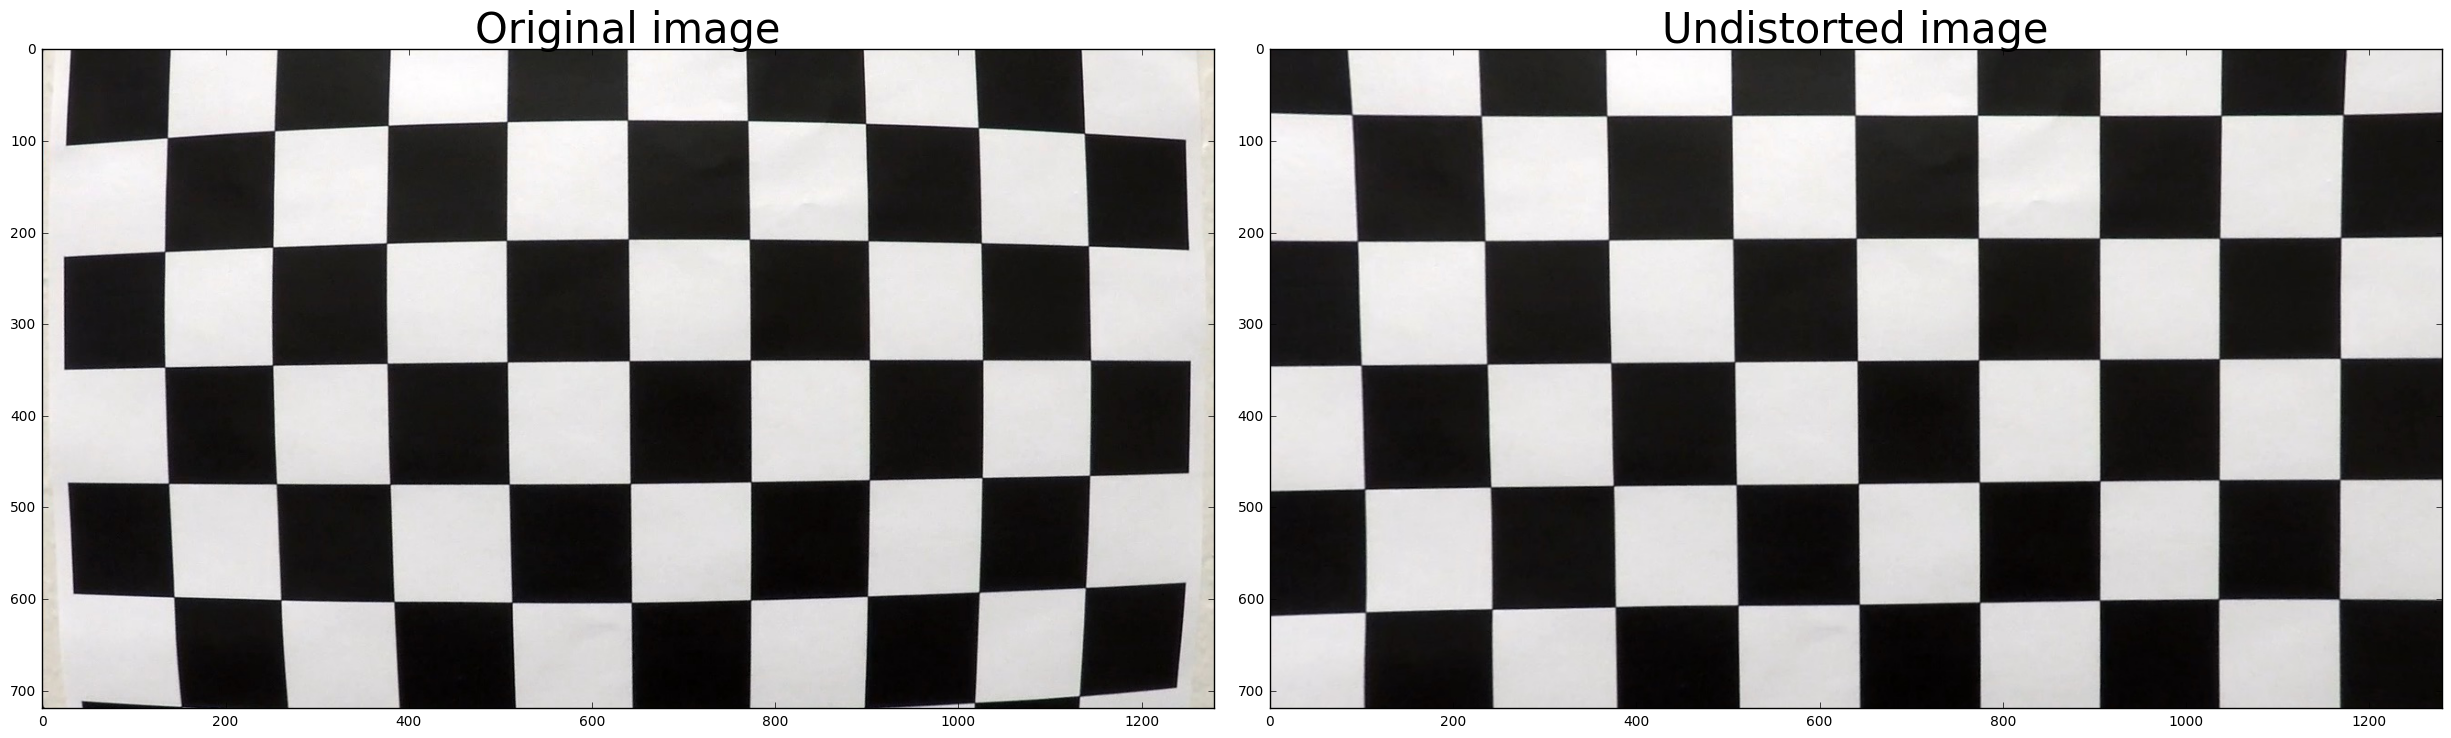

In [4]:
# Test undistortion on an calibration image
fname = "../camera_cal/calibration1.jpg"
print("Testing undistortion on image:  "+ fname)
#img = cv2.imread(fname)
img = mpimg.imread(fname)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size,None,None)
undst = cv2.undistort(img, mtx, dist, None, mtx)

# Plot the result
plot_result(img,undst,title_start='Original image', title_end='Undistorted image')
mpimg.imsave('../output_images/undistorted_chessboard.jpg', undst)

---
## 2. Apply a distortion correction to raw images

#####  Functions definition for camera calibration

In [5]:
def calibrate_img(objpoints,imgpoints,img):
    ''' Apply calibration to a given image and return the calibrate image'''
    
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undst

##### Apply undistortion on test image 

Applying undistortion to the image: ../test_images/test2.jpg


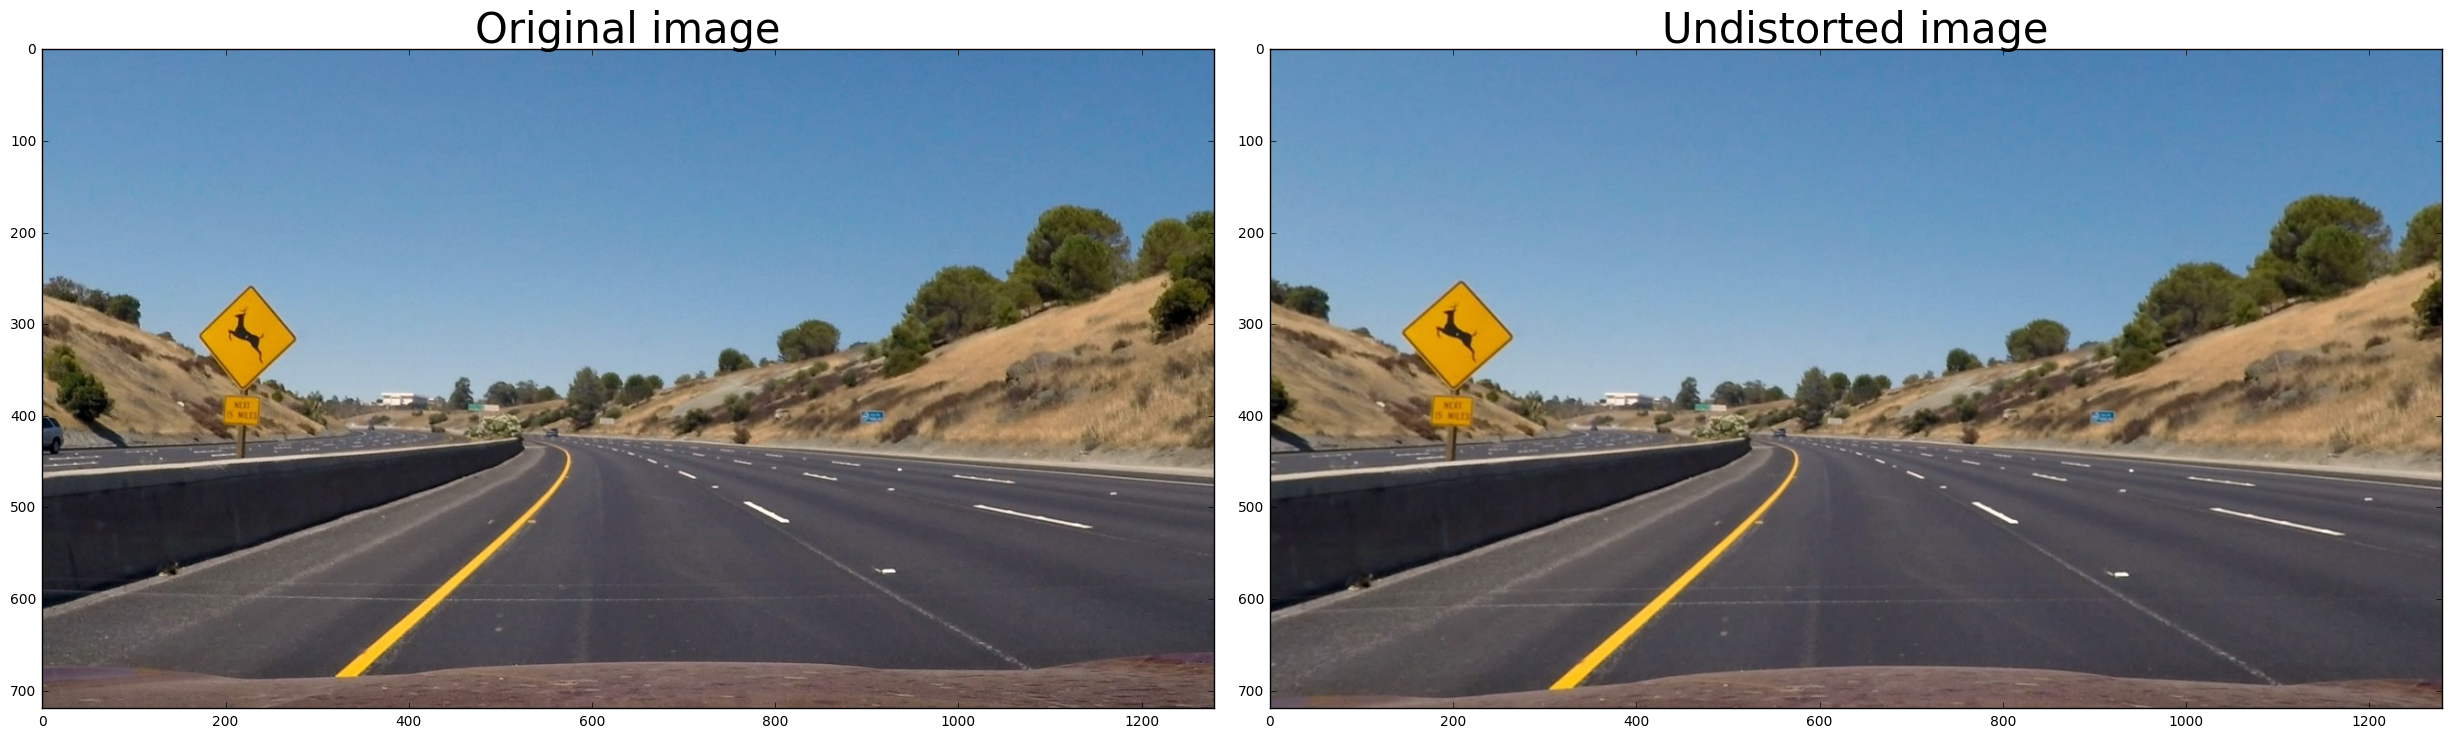

In [6]:
# Load a test image
picture_name='test2.jpg'
fname = "../test_images/"+ picture_name
img = mpimg.imread(fname) 

# Apply undistortion on the test image
print("Applying undistortion to the image: "+ fname)
undst_img = calibrate_img(objpoints,imgpoints,img)

plot_result(img,undst_img,title_start='Original image', title_end='Undistorted image')
mpimg.imsave('../output_images/undistorted_road.jpg', undst_img)

---
## 3. Create a thresholded binary image

#####  Functions for image transformation 

In [7]:
# Some functions in this cell require a gray image as input

# Apply Sobel transformation
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''
    Define a function to return a binary image one Sobel tranformation is applied,
    given sobel kernel size and threshold values
    '''
    
    # Calculate directional gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
      
    # Create a copy 
    grad_binary = np.zeros_like(scaled_sobel)
    
    # Apply threshold
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary


def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    Define a function to return the magnitude of the gradient
    for a given sobel kernel size and threshold values
    Require a gray image
    '''

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Apply threshold
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image   
    return mag_binary


# Threshold the gradient direction in both x & y directions
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    Define a function to threshold an image for a given range and Sobel kernel
    Require a gray image
    '''
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate gradient direction
    abs_grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    dir_binary =  np.zeros_like(abs_grad_dir)
    # Apply threshold
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary


# Threshold the S-channel of HLS
def hls_select(image,channel=2,thresh=(0, 255)):
    ''' Threshold the S-channel of HLS - Requires a color image as input'''
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,channel]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


##### Task pipeline(s)

In [8]:
def pipeline2_thresholded_binary(img, plot_switch=False):
    ''' Take a rgb undistorted image and return a binary image 
        
        This function allow to inspect differento solutions but should be use for testing only        
        
        For a quicker use, when the algo has been defined, use the alternative 
        short_pipeline2_thresholded_binary function
        
        Setting plot_switch=True allows to visually examine different parameter choices 
    '''
        
    # Choose a Sobel kernel size
    ksize = 3
    gray_image  =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply the available functions    
    gradx  =  abs_sobel_thresh(gray_image, orient='x', sobel_kernel=ksize, thresh=(20,135))#20,135
    grady  =  abs_sobel_thresh(gray_image, orient='y', sobel_kernel=ksize, thresh=(20,120)) #10,160
    mag_binary  =   mag_thresh(gray_image, sobel_kernel=ksize, mag_thresh=(20,135)) # 15, 190
    dir_binary = dir_threshold(gray_image, sobel_kernel=ksize, thresh=(0.9, 1.1))
    hls_binary = hls_select(img,thresh=(170, 255))
    
    # Combine the result in different images - for an easier comparison
    combined = np.zeros_like(gray_image)
    combined_bn = np.zeros_like(gray_image)
    
    combined[(
        (hls_binary == 1) | 
        ((dir_binary == 1) & (mag_binary == 1)) |
        ((grady == 1) & (gradx == 1))
        )] = 1
    combined_bn[(
        ((dir_binary == 1) & (mag_binary == 1)) |
        ((grady == 1) & (gradx == 1))
        )] = 1
    
    # This returns a stack of two binary images, whose components you can see as different colors
    combined_color = np.dstack((hls_binary, np.zeros_like(combined),combined_bn))*255
    
    # Plot the results
    if plot_switch:
        plot_result(gradx,grady,title_start='Thresholded Gradient x',
                title_end='Thresholded Gradient y',gray_start=True,gray_end=True)
        plot_result(mag_binary,hls_binary,title_start='Magnitude Gradient',
                title_end='Thresholded S',gray_start=True,gray_end=True)
        plot_result(dir_binary,combined_bn,title_start='Direction of the gradient',
                title_end='Combined_bn',gray_start=True,gray_end=True)        
        plot_result(combined_color,combined,title_start='Adding S (red)',
                title_end='Combined',gray_start=False,gray_end=True)

    return combined

# Actual image's pipeline
def short_pipeline2_thresholded_binary(img):
    ''' Take a rgb undistorted image and return a binary image, to input for lane detection'''
    
    # Fix a Sobel kernel size
    ksize = 3
    gray_image  =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gradx  =  abs_sobel_thresh(gray_image, orient='x', sobel_kernel=ksize, thresh=(20,135))#20,135
    grady  =  abs_sobel_thresh(gray_image, orient='y', sobel_kernel=ksize, thresh=(20,120)) #10,160
    mag_binary  =   mag_thresh(gray_image, sobel_kernel=ksize, mag_thresh=(20,135)) # 15, 190
    dir_binary = dir_threshold(gray_image, sobel_kernel=ksize, thresh=(0.9, 1.1))
    hls_binary = hls_select(img,thresh=(170, 255))
    
    combined = np.zeros_like(gray_image)
    combined[(
        (hls_binary == 1) | 
        ((dir_binary == 1) & (mag_binary == 1)) |
        ((grady == 1) & (gradx == 1))
        )] = 1
    
    return combined

##### Testing results

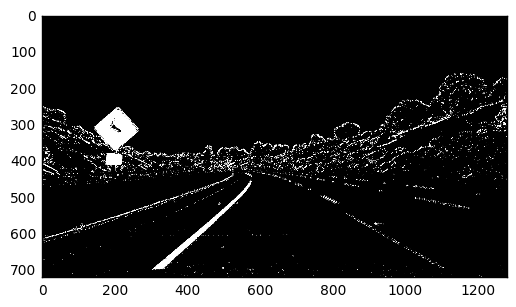

In [9]:
# Uncomment the following lane for testing alternatives
#binary_combine = pipeline2_thresholded_binary(undst_img,plot_switch=True)

# Apply transformation to an undistorted image and show the result
binary_combine = short_pipeline2_thresholded_binary(undst_img)
plt.imshow(binary_combine,cmap='gray')
plt.show()
mpimg.imsave('../output_images/binary_combine.jpg', binary_combine, cmap='gray')

---
## 4. Apply a perspective transform to rectify binary image ("birds-eye view")

In [10]:
# Parameters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

#####  Functions for masking images

In [11]:
def polygon_from_shape(imshape, delta=0.6, d=40):
    """
    `poligon_from_shape` identifies a symmetric isosceles trapezoid
    following the steps below:
    - fix the base of the poligon at the bottom of the picture, with length imshape[1]
    - define a isosceles triangle, by its heigth set by the "delta" parameter:
        if in the middle of the picture the delta value is 0.5
        and if can be freely moved anywhere to the top (delta=0) 
        or to the bottom (delta=1). The default value is 0.6
    - cut a little triangle - from the top of the one just made -
         with heigth "d" pixels (default d=40)
    
    Once cut is made, you get your centered polygon
       
    """    
    H = imshape[0] # vertical length
    B = imshape[1] # horizontal length

    # set the height of the triangle (with a vertex in the (horizontal) middle of the picture)
    h = H * delta

    # set s, the small half-base of the small tringle 
    myRatio = float(B) / float(h)
    s = int (d * myRatio / 2.)
    
    # draw the four sided polygon to mask
    vertices = np.array([[(0,H),(B/2-s, h+d), (B/2+s, h+d), (B,H)]], dtype=np.int32)
    h_and_d = h+d # distan#print(vertices, h_d)
    
    return vertices, h_and_d


def region_of_interest(an_img, vertices):
    """
    Applies an image mask to obtain a selection of the original one
    
    Only keep the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # Define a blank mask to start with
    mask = np.zeros_like(an_img)   
    
    # Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(an_img.shape) > 2:
        channel_count = an_img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly (mask, vertices, ignore_mask_color)
    
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and (an_img, mask)
    
    return masked_image

#####  Functions for drawing (straight) lanes

In [12]:
def lane_from_lines(an_img,two_lines,h_d,h_max):
    """
    `lane_from_lines` return left and rigth lanes source points as well their b/n image
    from the lateral sides of a trapeziod
    
    Input: red lanes (two_lines) as drawn over a black picture .
    Also, it needs "h_d" the heigth of the trapezoid
    and "h_max" the total height of the final picture.
    
    """
    # Create a blank to draw lines on - 
    line_image = np.copy(an_img)*0 

    # Extract point
    x1=np.reshape(np.hstack(two_lines),[len(two_lines),4])[:,0]
    y1=np.reshape(np.hstack(two_lines),[len(two_lines),4])[:,1]
    x2=np.reshape(np.hstack(two_lines),[len(two_lines),4])[:,2]
    y2=np.reshape(np.hstack(two_lines),[len(two_lines),4])[:,3]
    
    # y = mx + q
    # NOTE: henceforth we work with y axis rolled up-down (x is ok)
    
    # Check for vertical lines
    m_inf = ((x2-x1) == 0) | ((y2-y1) == 0)
    
    # set m and q to 0.
    m = x1 * 0.
    q = y1 * 0.

    # m and q will assume a decent value or stay zero
    m[~m_inf] = (y2[~m_inf] - y1[~m_inf]) / (x2[~m_inf] - x1[~m_inf])    
    q[~m_inf] =  y2[~m_inf] -  m[~m_inf]  *  x2[~m_inf] 
    
    top_x    = x1 * 0. # if rare and still 0 median should exclude it
    bottom_x = x1 * 0. # if rare and still 0 median should exclude it
    top_x[~m_inf]    = (h_d   - q[~m_inf]) / m[~m_inf]
    bottom_x[~m_inf] = (h_max - q[~m_inf]) / m[~m_inf]
        
    rigth = m > 0 # the image is rolled up-down!
        
    # Draw left line
    x1L = int(np.median(bottom_x[~rigth])+0.5) # median is more robust than any mean
    y1L = int(h_max)
    x2L = int(np.median(top_x   [~rigth])+0.5)
    y2L = int(h_d)
    cv2.line(line_image,(x1L,y1L),(x2L,y2L),(255,0,0),10)
    
    # Draw rigth line
    x1R = int(np.median(bottom_x[rigth])+0.5)
    y1R = int(h_max)
    x2R = int(np.median(top_x   [rigth])+0.5)
    y2R = int(h_d)
    cv2.line(line_image,(x1R,y1R),(x2R,y2R),(255,0,0),10)
    
    # Line source points
    lines_src = np.float32([[x1L,y1L],[x2L,y2L],[x2R,y2R],[x1R,y1R]])
    
    return line_image,lines_src
    

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

##### Function for getting source points of perspectve transformation 

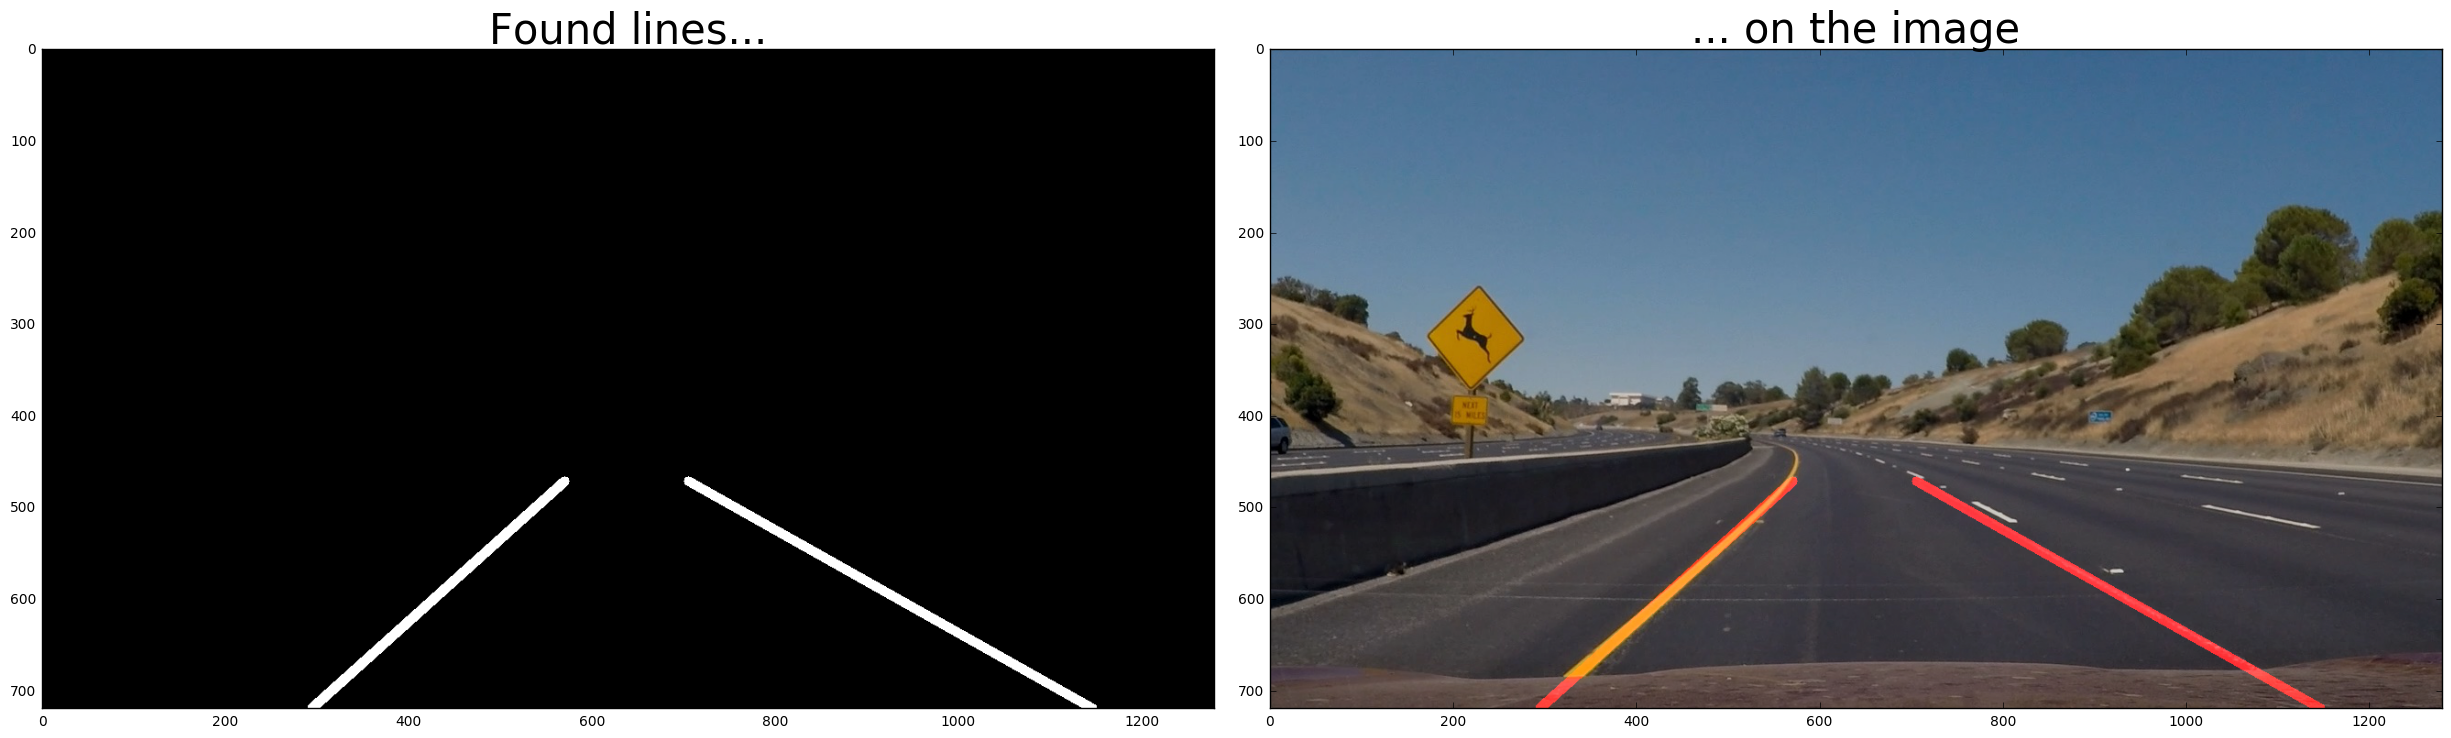

  Source points:
 [[  294.   720.]
 [  570.   472.]
 [  705.   472.]
 [ 1146.   720.]]


In [13]:
def get_source_points(binary_combine):
    '''
    Given a binary image, find a straight lane in it
    and return the sources (src) points of the two lines that limit the lane 
    Also show some pictures while processing the image 
    '''
    # Get the binary transformet image
    imshape = binary_combine.shape
    
    # Select a relevant area
    vertices,h_and_d = polygon_from_shape(imshape)
    
    # Mask the image
    masked_image = region_of_interest(binary_combine, vertices)
    
    # Find the two lines
    lines = cv2.HoughLinesP(masked_image, rho= 1., theta=np.pi/180, threshold=50, lines=np.array([]),
                            minLineLength=35, maxLineGap=10)
    
    # Create an image select trace of the plausible HoughLinesP lines 
    line_img = np.zeros((*masked_image.shape, 3), dtype=np.uint8)
    draw_lines(line_img,lines)
    
    # Draw the two lines (black and white) and their source points
    line_image, src = lane_from_lines(masked_image,lines,h_and_d,imshape[0])
    
    # Add lines to the original picture
    dummy = line_image[...,None] # add a channel
    dummy = np.dstack((dummy, np.zeros_like(dummy),np.zeros_like(dummy)))
    combo = cv2.addWeighted(img, 0.8, dummy,1., 0) 
    
    # Show lines 
    plot_result(line_image,combo,
                title_start='Found lines...',title_end='... on the image',
                gray_start=True,gray_end=False)
    
    return src
    
    
src = get_source_points(binary_combine) 
print("  Source points:\n",src)

NOTE:  
While the left line is well designed, the rigth one is somehow foolished by a noising internal line mark on the road just starting at the bottom of the picture. 

##### Function for getting destination points of perspectve transformation

In [14]:
def align_trapezoid(binary_combine,len_line=30, ratio=1):
    '''
    Given a binary image, 
    take into account the estimated length in meters 
    of the two lines found in the picture 
    and return the destination point of the rectangle 
    in a perspective transformed image
    '''
    
    imgsize = binary_combine.shape[1],binary_combine.shape[0]
    
    b = imgsize[0]
    h = imgsize[1]
    
    # Take into account conversions in x and y from pixels space to meters    
    half_base = int(700/2) # set the base proportional to the height
    upper_points = h - int((len_line / ym_per_pix) + .5)
    
    # Set the destination points
    dst = np.float32([[int(b/2+.5)-half_base,h],
                          [int(b/2+.5)-half_base,upper_points],
                          [int(b/2+.5)+half_base,upper_points],
                          [int(b/2+.5)+half_base,h]
                         ])
    return dst 

dst = align_trapezoid(binary_combine)
print(" Destination points:\n",dst)

 Destination points:
 [[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


##### Apply a perspective transform

In [15]:
def get_warped_images(undst_img_p,binary_combine_p,src,dst):
    '''
    Apply PerspectiveTransform to undistorted images 
    and return birds-eye view of binary and color images.
    Also return transformation and inverse transformation parameters.
    
    '''
    # Get image dimension 
    imgsize = binary_combine_p.shape[1],binary_combine_p.shape[0]
    
    # Calculate transorm and inverse transform parameters
    M    = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Obtain warped images
    warped_p = cv2.warpPerspective(undst_img_p,M,imgsize,flags=cv2.INTER_LINEAR)
    binary_warped_p = cv2.warpPerspective(binary_combine_p, M, imgsize,flags=cv2.INTER_LINEAR)
    
    # Return calculated objects
    return M,Minv,warped_p,binary_warped_p


M, Minv, warped, binary_warped = get_warped_images(undst_img,binary_combine,src,dst)

##### Testing results of a perspective transform

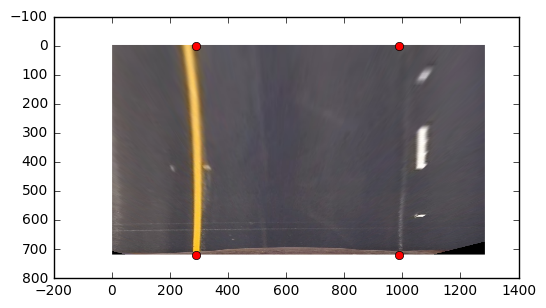

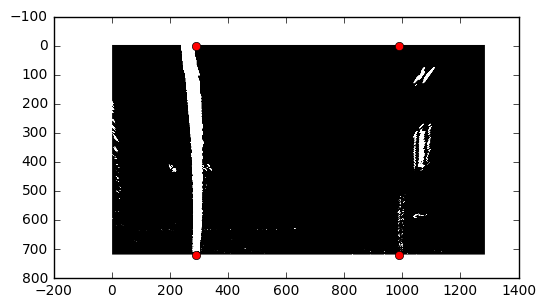

In [16]:
plt.imshow(warped)

# Mark images with destination points
plt.plot(dst[0][0],dst[0][1],'o',color='red')
plt.plot(dst[1][0],dst[1][1],'o',color='red')
plt.plot(dst[2][0],dst[2][1],'o',color='red')
plt.plot(dst[3][0],dst[3][1],'o',color='red')
plt.show()


plt.imshow(binary_warped,cmap='gray')
plt.plot(dst[0][0],dst[0][1],'o',color='red')
plt.plot(dst[1][0],dst[1][1],'o',color='red')
plt.plot(dst[2][0],dst[2][1],'o',color='red')
plt.plot(dst[3][0],dst[3][1],'o',color='red')
plt.show()
mpimg.imsave('../output_images/binary_warped.jpg', binary_warped, cmap='gray')

---
## 5. Detect lane pixels and fit to find the lane boundary.

##### Function for finding (curved) line boundaries 

In [17]:
# Function to inspect and study characteristics of the images
def find_lane_boundary (binary_warped, plot_switch= False):
    ''' Given a warped binary image, for both left and right lines" 
    return:
    - the coefficients of a polynomial degree 2
    - the fitted values
    - two wheights to apply when averaging left and right curves
        to determine the car radius of cirvature
        
    This function is merely uset for studying purposes
    When running, prefer the faster fast_find(binary_warped) function'''
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Determine the relative weights of the two lanes based on their "relevance"
    left_weight  = np.max (histogram[:midpoint])
    right_weight = np.max (histogram[midpoint:])
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero  = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low  = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(
            win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(
            win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
            nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
            nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit =  np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    if(plot_switch):
        
        plt.plot(histogram)
        plt.xlim(0, 1280)
        plt.show() # Plots are shown vertically for a better intuition of what is happening
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds],   nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        # Create an image to draw on and an image to show the selection window
        window_img = np.zeros_like(out_img)
    
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)

        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0) 
        #mpimg.imsave('../polynomial.jpg', result)
        plt.savefig('../output_images/polynomial.jpg')
        
    return left_fit, right_fit, left_weight, right_weight, left_fitx, right_fitx


def fast_find(binary_warped):
    ''' Given a warped binary image, for both left and right lines" 
    This function return:
    - the coefficients of a polynomial degree 2 for both left and right lines
    - their fitted values
    '''

    global left_fit,right_fit
    
    # Find non zero values in warped image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Identify the nonzero pixels in x and y within the window
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + 
                                   left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                                   left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) +
                                    right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                                    right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit,right_fit,left_fitx,right_fitx

##### Finding curves boundaries on test image

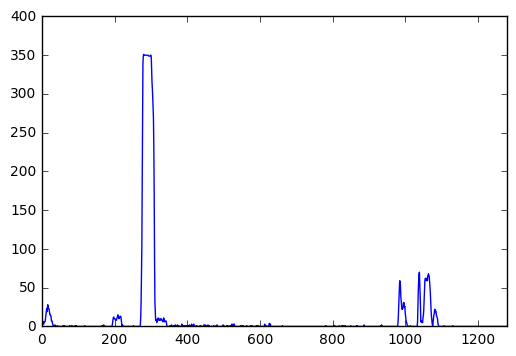

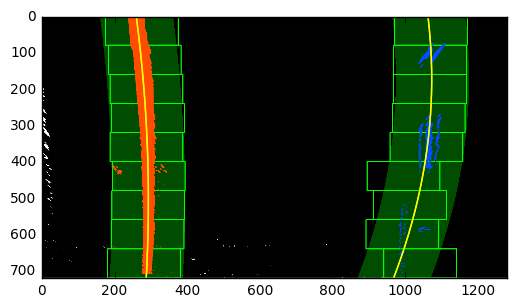

In [18]:
# Apply the function to find lines and other information on the test image
left_fit,right_fit,\
left_weight,right_weight,\
left_fitx,right_fitx = find_lane_boundary (binary_warped, plot_switch=True)

---
## 6. Determine the curvature of the lane and vehicle position with respect to center

#####  Functions definition 

In [19]:
# Parameters

# Cover same y-range as image
ploty = np.linspace(0, 719, num=720)
# Define y-value where we want radius of curvature corresponding to the bottom of the image 
y_eval = np.max(ploty)
    

def away_from_center(img_size,src,xm_per_pix):  
    ''' Find the istance from the center of the lane, in meters
    Return the distance and the text to plot on the image'''
    
    b = img_size[0]
    down_l = src[0][0]
    down_r = src[3][0]
    
    away = (down_r+down_l-b)/2.  
    away_m = away * xm_per_pix   
    
    text = 'Position with respect to center of the lane: {0:.1f} m right'.format(abs(away_m))
    if away > 0.:
        text = 'Position with respect to center of the lane: {0:.1f} m left'.format(away_m)
    else:
        if(away > 0.):
            text = "*--- Middle of the lane ---*"
    return away,text


def curvature (left_weight=1.,right_weight=1.,plot_switch=False):
    ''' Find the weighted average (if given as parameter) of the curvature of the two lines, in kilometers
    Return the (ave)radius and the text to plot on the image
    First find curvature in in pixels 
    and then convert in meters via meter-scaled simulated data'''
    
    global left_fit,right_fit
    
    left_curverad  = ((1 + (2* left_fit[0]*y_eval +  left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx = np.array([np.polyval(left_fit ,y)+ np.random.randint(-50, high=51)
                      for y in ploty])
    rightx= np.array([np.polyval(right_fit,y)+ np.random.randint(-50, high=51)
                      for y in ploty])

    leftx = leftx[::-1]    # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if plot_switch:
        # Plot up the data simulated
        mark_size = 3
        plt.plot(leftx, ploty,  'o', color='red',  markersize=mark_size)
        plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx,  ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
        plt.show()

    # Fit new polynomials to x,y in world space
    left_fit_cr  = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad_m  = ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix +
                              left_fit_cr[1])**2)**1.5) / np.absolute(2* left_fit_cr[0])
    right_curverad_m = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + 
                              right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Determine radius of curvature is in kilometers
    my_radius = (
        (right_curverad_m*right_weight)+(left_curverad_m*left_weight))/(
        right_weight+left_weight)/1000.
    text = 'Radius of curvature: {0:.1f} km'.format(my_radius)
    
    return my_radius,text

##### Finding position an curvature of the test image

In [20]:
away_est,text1 = away_from_center(img_size,src,xm_per_pix)
print (text1)
curve_est,text2 = curvature (left_weight=1.,right_weight=1.,plot_switch=False)
print (text2)

Position with respect to center of the lane: 0.4 m left
Radius of curvature: 0.9 km


---
## 7. Warp the detected lane boundaries back onto the original image

#####  Functions definition

In [21]:
def back_warp_image(img_q,warped_p,left_fitx,right_fitx):
    ''' Return the original image with the lane paved in green'''
    
    img_p = np.copy(img_q)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_p).astype(np.uint8)
    color_warp = warp_zero

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left  = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_p, 1, newwarp, 0.3, 0)
    
    return result
    
# For results, see next chapter

---
## 8. Display lane boundaries and estimation of lane curvature and vehicle position

#####  Functions definition

In [22]:
def write_on_image(result_p,src_p,text_curv,text_dist):
    ''' Write information on the image '''
    
    global left_fit,right_fit
    result_q = np.copy(result_p)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_SIMPLEX
    away,text1      = away_from_center(img_size,src_p,xm_per_pix)
    my_radius,text2 = curvature (left_weight,right_weight,plot_switch=False)
    
    cv2.putText(result_q,text_curv,(50, 50), font, 1.15,(255,255,255),2)
    cv2.putText(result_q,text_dist,(50,100), font, 1.15,(255,255,255),2)
    
    return result_q

##### Showing results

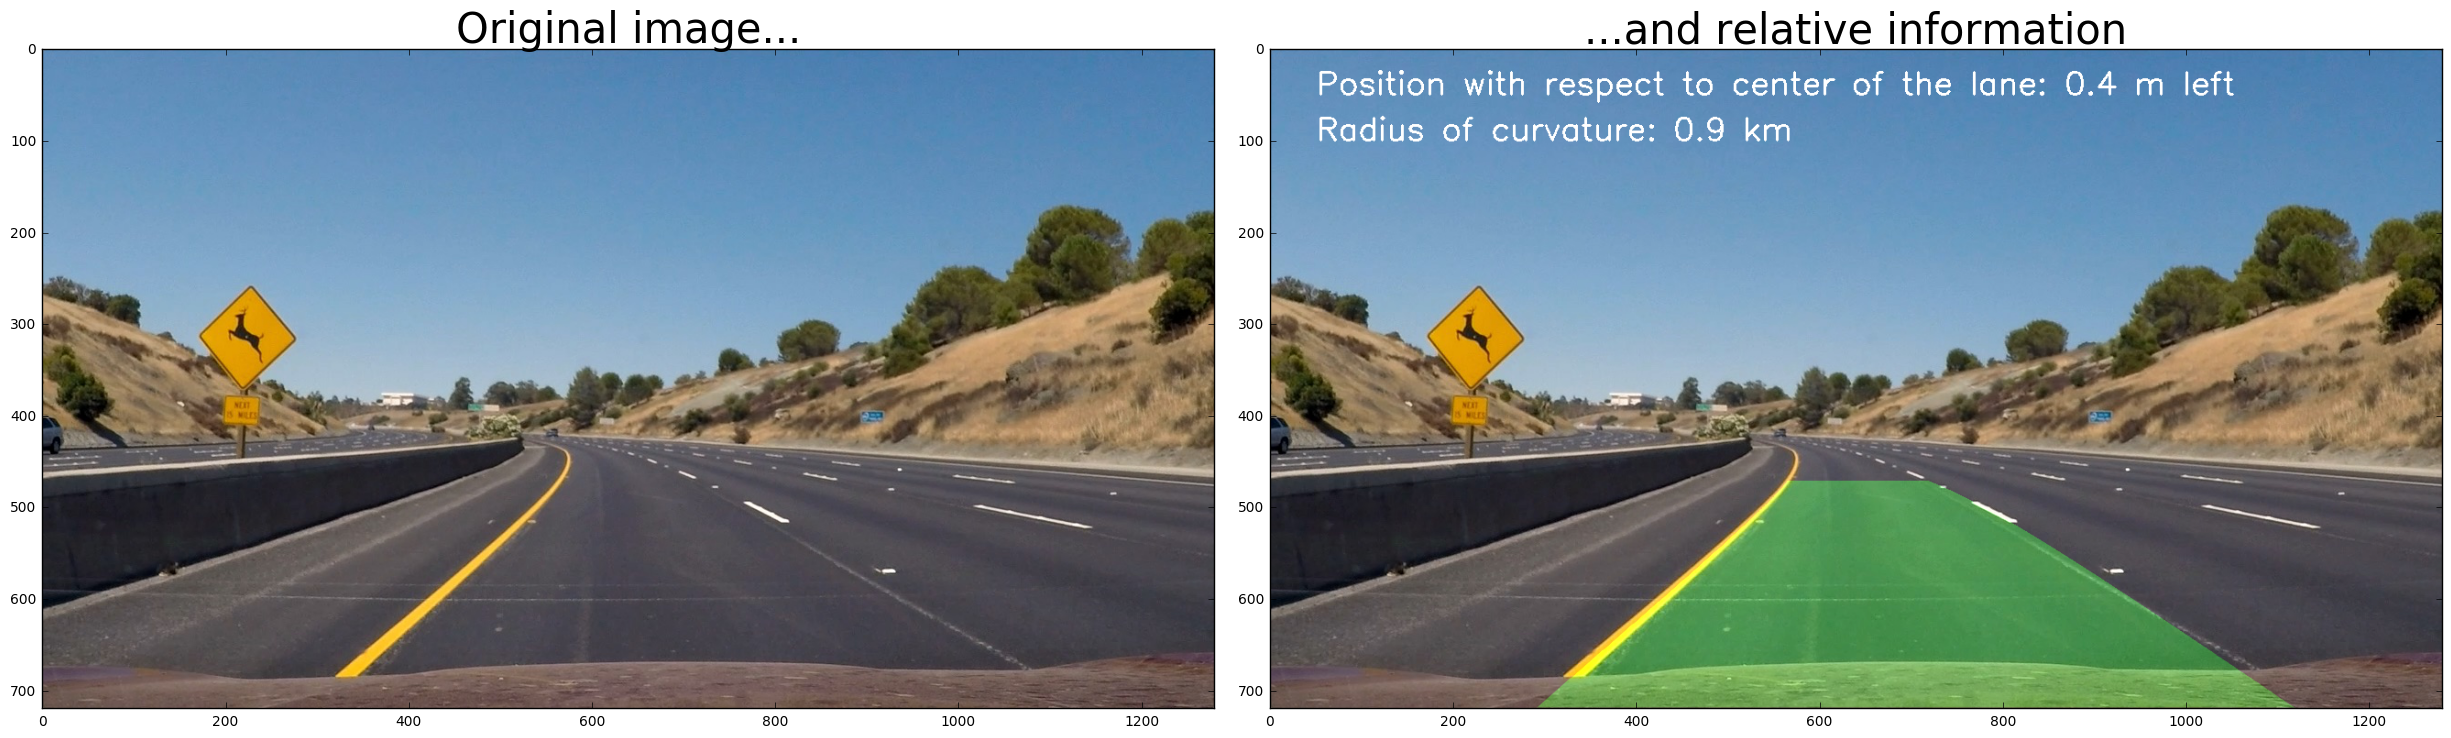

In [23]:
result_blank = back_warp_image(img,warped,left_fitx,right_fitx)
result_info=  write_on_image(result_blank,src,text1,text2)
plot_result(img,result_info, title_start='Original image...',title_end='...and relative information')
mpimg.imsave('../output_images/green_carpet.jpg', result_info)

---
## Applying to a videoclip

##### Define a class to manage lines

In [25]:
# Define a class to receive the characteristics of each line detection
# Here is only partially used
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # set the n fits
        self.n = None
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def find_bestx(self):
        ''' Average on stored values'''
        self.bestx = np.mean(self.recent_xfitted,axis=0)
        
    def update_x(self,xfit):
        ''' Roll over the values and update the more recent one'''
        if self.detected:
            del(self.recent_xfitted[0])
            self.recent_xfitted.append(xfit)
        else:
            self.recent_xfitted = [xfit] * self.n
            self.detected = True
        self.find_bestx()
    
    def update_radius(self, radius):
        ''' 
        Store the radius value for later use
        Simple check of big anomalies in radius
        '''
        if self.radius_of_curvature== None:
            pass
        elif (self.radius_of_curvature>0):
            if(radius / self.radius_of_curvature > 3):
                self.recent_xfitted[n-1]=self.recent_xfitted[n-2]
        self.radius_of_curvature = radius       
                    

In [26]:
# Initialise the story-Lines dimension
n = 10
left_line  = Line();left_line.n = n
right_line = Line();right_line.n = n

##### Pipeline for videoclips

In [27]:
def process_image(video_img):
    global left_fit,right_fit
   
    # Calibrate
    video_undst_img = calibrate_img(objpoints,imgpoints,video_img)
    
    # Obtain binary image 
    video_binary = short_pipeline2_thresholded_binary(video_undst_img)
    
    # Obtain warped image 
    a,b,video_warped,video_binary_warped = get_warped_images(video_undst_img,
                                                             video_binary,
                                                             src,dst)
    # Get parameters and values from applying polynomial
    left_fit,right_fit,left_fitx,right_fitx = fast_find(video_binary_warped)
    
    # Update lines values
    left_line.update_x(left_fitx)
    right_line.update_x(right_fitx)
    left_fitx = left_line.bestx
    right_fitx = right_line.bestx

    # Update source values
    new_src = src * 0
    new_src[0][0]=left_fitx[719]
    new_src[3][0]=right_fitx[719]

    # Calculate radius and position on the lane
    my_radius,text1 = curvature ()
    away,text2 = away_from_center(img_size,new_src,xm_per_pix)
    
    left_line.update_radius(my_radius)
    left_line.line_base_pos = away 
    
    # Backwarp and write on image for displaying
    result_1= back_warp_image(video_img,video_warped,left_fitx,right_fitx)
    result= write_on_image(result_1,new_src,text1,text2)

    return result

white_output = '../my_project_video.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../my_project_video.mp4
[MoviePy] Writing video ../my_project_video.mp4


100%|█████████▉| 1260/1261 [33:47<00:01,  1.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../my_project_video.mp4 

CPU times: user 33min 43s, sys: 1min 44s, total: 35min 28s
Wall time: 33min 49s
